In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
ls /kaggle/input/*/

data_object_calib/    data_object_image_3/
data_object_image_2/  data_object_label_2/


# Libraries

In [3]:
import os
from collections import Counter
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import numpy as np

In [4]:
labels_dir = "/kaggle/input/kitti-dataset/data_object_label_2/training/label_2/"
image_dir = "/kaggle/input/kitti-dataset/data_object_image_2/training/image_2/"

# Read Image

In [5]:
def read_image(image_name):
    image_path = os.path.join(image_dir, f"{image_name}.png") 
    image = cv2.imread(image_path)

    if image is None:
        raise FileNotFoundError(f"Not Found: {image_path}")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(f"Image shape: {image.shape}")
    return image


Image shape: (375, 1242, 3)


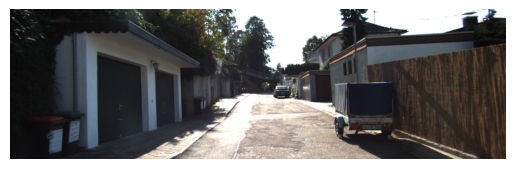

In [6]:
image = read_image("000002")
plt.imshow(image)
plt.axis("off")
plt.show()

# Data Exploration

Count the occurrences of each object class in the KITTI dataset labels and visualize the distribution using a bar chart.

In [7]:
def label_counts_distribution():
    label_counts = Counter()
    for label_file in os.listdir(labels_dir):
        with open(os.path.join(labels_dir, label_file), "r") as file:
            for line in file:
                class_name = line.split()[0] 
                label_counts[class_name] += 1 
    return label_counts


Distribution
Car: 28742
Van: 2914
DontCare: 11295
Misc: 973
Cyclist: 1627
Pedestrian: 4487
Truck: 1094
Tram: 511
Person_sitting: 222


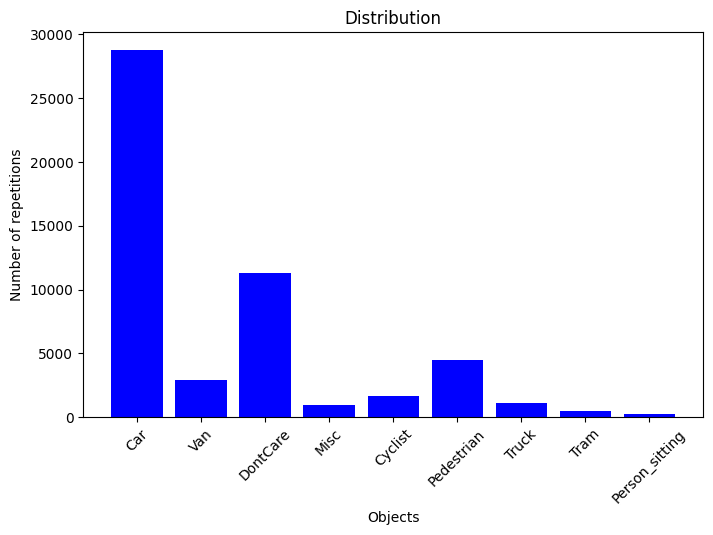

In [8]:
label_counts = label_counts_distribution()

print("Distribution")
for label, count in label_counts.items():
    print(f"{label}: {count}")

plt.figure(figsize=(8, 5))
plt.bar(label_counts.keys(), label_counts.values(), color='blue')
plt.xlabel("Objects")
plt.ylabel("Number of repetitions")
plt.title("Distribution")
plt.xticks(rotation=45)
plt.show()

## Data Quality Analysis

### Image Resolution

In [9]:
def image_resolutions():
    resolutions = []
    for image_file in os.listdir(image_dir):
        image_path = os.path.join(image_dir, image_file)
        img = cv2.imread(image_path)
    
        if img is not None:
            resolutions.append(img.shape[:2])
    return np.array(resolutions)



In [10]:
resolutions = image_resolutions()
unique_resolutions = np.unique(resolutions, axis=0)
print("Unique Image Resolutions:", unique_resolutions)

Unique Image Resolutions: [[ 370 1224]
 [ 374 1238]
 [ 375 1242]
 [ 376 1241]]


### Bounding Box

This method reads a label file, extracts bounding box coordinates for detected objects, and retrieves environmental tags (e.g., weather, lighting) along with the road type. It returns a list of bounding boxes, environment tags, and the road type.

In [11]:
def extract_bounding_boxes_and_tags(imageName):
    bounding_boxes = [] 
    environment_tags = []
    road_type = ""
    label_path = f"{labels_dir}{imageName}.txt"
    if os.path.exists(label_path):
        with open(label_path, "r") as file:
            for line in file:
                values = line.split()
                if values[0] != 'DontCare':
                    x_min, y_min, x_max, y_max = map(float, values[4:8])
                    bounding_boxes.append((x_min, y_min, x_max, y_max))
                    environment_tags = values[-4:-1] 
                    road_type = values[-1] 
    else:
        print(f"Not Found: {label_path}")

    return bounding_boxes, environment_tags, road_type

Image shape: (375, 1242, 3)
(564.62, 174.59, 616.43, 224.74)
(481.59, 180.09, 512.55, 202.42)
(542.05, 175.55, 565.27, 193.79)
(330.6, 176.09, 355.61, 213.6)


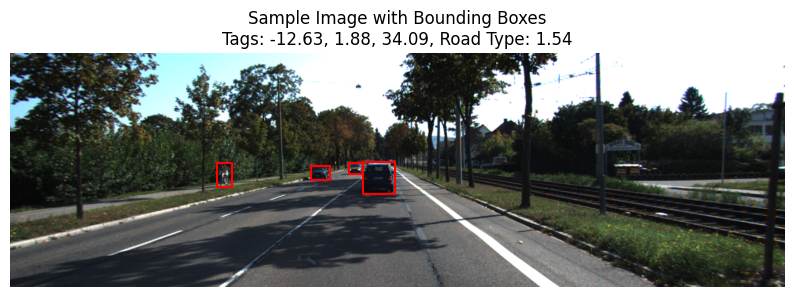

In [12]:

imageName = "000007"
img = read_image(imageName)

bounding_boxes, environment_tags, road_type = extract_bounding_boxes_and_tags(imageName)

environment_info = ", ".join(environment_tags) if environment_tags else "N/A"
title_text = f"Sample Image with Bounding Boxes\nTags: {environment_info}, Road Type: {road_type}"


plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis("off")
plt.title(title_text)


for bbox in bounding_boxes:
    print(bbox)
    x_min, y_min, x_max, y_max = bbox
    plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], color='red')

plt.show()



### Detect Biases

function extracts the center coordinates (x_center, y_center) of bounding boxes from label files in labels_dir, grouping them by object class in a dictionary. 
It returns a dictionary where keys are object classes and values are lists of center positions.

In [13]:
# def detect_box_positions():
#     bbox_positions = {}
#     for label_file in os.listdir(labels_dir):
#         with open(os.path.join(labels_dir, label_file), "r") as file:
#             for line in file:
#                 parts = line.split()
#                 class_id = parts[0]  
#                 x_center, y_center = map(float, parts[1:3])  

#                 if class_id != "DontCare":
#                     if class_id not in bbox_positions:
#                         bbox_positions[class_id] = []
                
#                     bbox_positions[class_id].append((x_center, y_center))
#     return bbox_positions

In [14]:
# bbox_positions = detect_box_positions()
# plt.figure(figsize=(10, 6))

# colors = ['red', 'blue', 'green', 'purple', 'orange']
# for i, (class_id, positions) in enumerate(bbox_positions.items()):
#     positions = np.array(positions)
#     plt.scatter(positions[:, 0], positions[:, 1], alpha=0.5, s=10, color=colors[i % len(colors)], label=f"Class {class_id}")

# plt.xlabel("X Center")
# plt.ylabel("Y Center")
# plt.title("Bounding Boxes")
# plt.gca().invert_yaxis()
# plt.legend()
# plt.show()


In [15]:
# if not (0 <= x_center <= 1) or not (0 <= y_center <= 1):
#     print(f"Warning: Invalid coordinates ({x_center}, {y_center}) in file {label_file}")


In [16]:
# bbox_positions = [pos for pos in bbox_positions if 0 <= pos[0] <= 1 and 0 <= pos[1] <= 1]
# bbox_positions

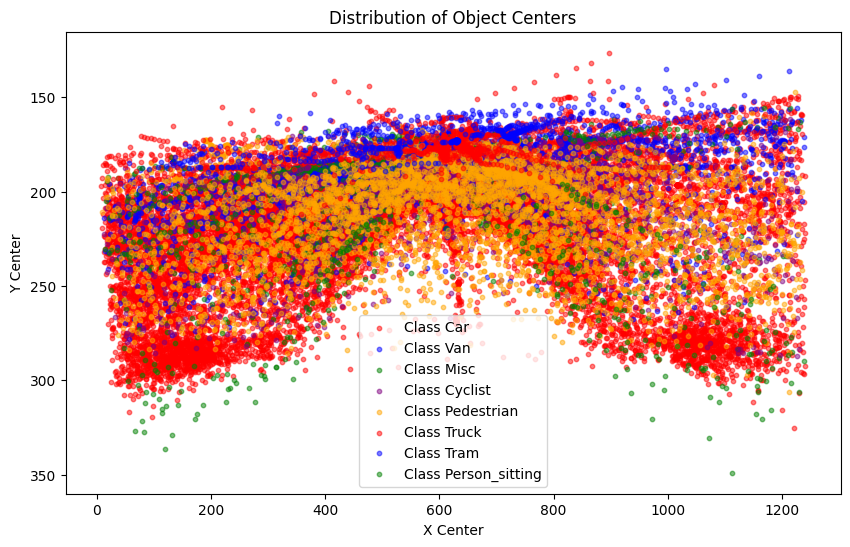

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt

labels_dir = "/kaggle/input/kitti-dataset/data_object_label_2/training/label_2/"

def detect_box_positions():
    bbox_positions = {}
    for label_file in os.listdir(labels_dir):
        with open(os.path.join(labels_dir, label_file), "r") as file:
            for line in file:
                parts = line.split()
                class_id = parts[0]  
                x_min, y_min, x_max, y_max = map(float, parts[4:8])  

                x_center = (x_min + x_max) / 2
                y_center = (y_min + y_max) / 2

                if class_id != "DontCare":
                    if class_id not in bbox_positions:
                        bbox_positions[class_id] = []
                
                    bbox_positions[class_id].append((x_center, y_center))
    return bbox_positions

bbox_positions = detect_box_positions()

plt.figure(figsize=(10, 6))
colors = ['red', 'blue', 'green', 'purple', 'orange']

for i, (class_id, positions) in enumerate(bbox_positions.items()):
    positions = np.array(positions)
    plt.scatter(positions[:, 0], positions[:, 1], alpha=0.5, s=10, color=colors[i % len(colors)], label=f"Class {class_id}")

plt.xlabel("X Center")
plt.ylabel("Y Center")
plt.title("Distribution of Object Centers")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

**Resizes** images to **416×416** using the **Letterbox** technique while maintaining aspect ratio. Adjusts **Bounding Box (BBox) coordinates** to account for scaling and padding effects. The updated images and modified annotation files are saved in the specified output directory.

In [18]:
# !pip install ultralytics

In [19]:
# import os
# from ultralytics.utils.ops import letterbox
# import cv2

# # Function to adjust the Bounding Box based on scale and padding
# def adjust_bbox(bbox, scale, pad):
#     pad_left, pad_top = pad
#     x_min_new = int(bbox[0] * scale + pad_left)
#     y_min_new = int(bbox[1] * scale + pad_top)
#     x_max_new = int(bbox[2] * scale + pad_left)
#     y_max_new = int(bbox[3] * scale + pad_top)
#     return [x_min_new, y_min_new, x_max_new, y_max_new]

# # Input image directory for KITTI
# input_dir = "path/to/kitti/images"  # Example: "dataset/KITTI/images"
# # Output directory to save resized images
# output_dir = "path/to/output/images"  # Example: "dataset/KITTI/resized_images"
# # Labels directory for KITTI dataset
# labels_dir = "path/to/kitti/labels"  # Example: "dataset/KITTI/labels"

# # Create output directory if it doesn't exist
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# # Loop through all the files in the image directory
# for img_name in os.listdir(input_dir):
#     # Check if the file is an image (jpg or png)
#     if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
#         img_path = os.path.join(input_dir, img_name)
#         image = cv2.imread(img_path)
        
#         # Ensure the image is read correctly
#         if image is None:
#             print(f"Unable to read image: {img_path}")
#             continue
        
#         # Apply Letterbox technique to resize the image to 416×416
#         resized_image, ratio, (dw, dh) = letterbox(image, new_shape=(416, 416), auto=True)
        
#         # Save the resized image
#         out_path = os.path.join(output_dir, img_name)
#         cv2.imwrite(out_path, resized_image)
#         print(f"Processed image: {img_name}")
        
#         # Update the labels
#         label_file_path = os.path.join(labels_dir, img_name.replace(".jpg", ".txt").replace(".jpeg", ".txt"))
        
#         if os.path.exists(label_file_path):
#             with open(label_file_path, 'r') as f:
#                 lines = f.readlines()

#             # Modify each bounding box in the label file
#             updated_labels = []
#             for line in lines:
#                 label_info = line.strip().split()
#                 bbox = list(map(float, label_info[4:]))  # Get the bbox coordinates [x_min, y_min, x_max, y_max]
                
#                 # Adjust the bbox based on scale and padding
#                 updated_bbox = adjust_bbox(bbox, ratio, (dw, dh))
                
#                 # Reassemble the label with the updated bbox
#                 updated_line = f"{label_info[0]} " + " ".join(map(str, updated_bbox)) + "\n"
#                 updated_labels.append(updated_line)

#             # Save the updated labels
#             with open(label_file_path, 'w') as f:
#                 f.writelines(updated_labels)
#                 print(f"Updated labels for image: {img_name}")


This is the same code

In [ ]:
import os
import cv2

# Function to adjust the bounding box based on separate scale factors for width and height
def adjust_bbox(bbox, scale_x, scale_y):
    x_min_new = int(bbox[0] * scale_x)
    y_min_new = int(bbox[1] * scale_y)
    x_max_new = int(bbox[2] * scale_x)
    y_max_new = int(bbox[3] * scale_y)
    return [x_min_new, y_min_new, x_max_new, y_max_new]

# Input image directory for KITTI
input_dir = "/kaggle/input/kitti-dataset/data_object_image_2/training/image_2/"  # Example: "dataset/KITTI/images"
# Output directory to save resized images
output_dir = "/kaggle/working/resized_images"  # Example: "dataset/KITTI/resized_images"
# Labels directory for the KITTI dataset
labels_dir = "/kaggle/working/updated_labels"  # Example: "dataset/KITTI/labels"

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loop through all the files in the image directory
for img_name in os.listdir(input_dir):
    # Check if the file is an image (jpg, jpeg, or png)
    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(input_dir, img_name)
        image = cv2.imread(img_path)
        
        # Ensure the image is read correctly
        if image is None:
            print(f"Unable to read image: {img_path}")
            continue
        
        # Get original image dimensions
        orig_h, orig_w = image.shape[:2]
        # Define new dimensions (width, height)
        new_w, new_h = 416, 416
        
        # Calculate scaling factors for width and height
        scale_x = new_w / orig_w
        scale_y = new_h / orig_h
        
        # Resize the image using cv2.resize
        resized_image = cv2.resize(image, (new_w, new_h))
        
        # Save the resized image
        out_path = os.path.join(output_dir, img_name)
        cv2.imwrite(out_path, resized_image)
        print(f"Processed image: {img_name}")
        
        # Update the labels
        # Update file extension for images (handles jpg, jpeg, and png)
        label_file_path = os.path.join(labels_dir, img_name.replace(".jpg", ".txt")
                                                        .replace(".jpeg", ".txt")
                                                        .replace(".png", ".txt"))
        
        if os.path.exists(label_file_path):
            with open(label_file_path, 'r') as f:
                lines = f.readlines()

            updated_labels = []
            for line in lines:
                label_info = line.strip().split()
                # Extract the bounding box coordinates: [x_min, y_min, x_max, y_max]
                bbox = list(map(float, label_info[4:8]))
                
                # Adjust the bounding box coordinates based on scaling factors
                updated_bbox = adjust_bbox(bbox, scale_x, scale_y)
                
                # Reassemble the line with the updated bounding box coordinates
                updated_line = f"{label_info[0]} " + " ".join(map(str, updated_bbox)) + "\n"
                updated_labels.append(updated_line)

            # Save the updated labels
            with open(label_file_path, 'w') as f:
                f.writelines(updated_labels)
                print(f"Updated labels for image: {img_name}")


Processed image: 005084.png
Processed image: 003065.png
Processed image: 003741.png
Processed image: 004725.png
Processed image: 001183.png
Processed image: 005660.png
Processed image: 007355.png
Processed image: 003244.png
Processed image: 002594.png
Processed image: 001703.png
Processed image: 003380.png
Processed image: 007190.png
Processed image: 004566.png
Processed image: 002584.png
Processed image: 004035.png
Processed image: 001840.png
Processed image: 005647.png
Processed image: 004924.png
Processed image: 005000.png
Processed image: 007456.png
Processed image: 006796.png
Processed image: 000419.png
Processed image: 002712.png
Processed image: 006386.png
Processed image: 000920.png
Processed image: 000585.png
Processed image: 001593.png
Processed image: 004178.png
Processed image: 002011.png
Processed image: 007203.png
Processed image: 004710.png
Processed image: 002312.png
Processed image: 003141.png
Processed image: 003053.png
Processed image: 006833.png
Processed image: 004

In [ ]:
def read_image2(image_name):
    image_path = os.path.join(output_dir, f"{image_name}.png") 
    image = cv2.imread(image_path)

    if image is None:
        raise FileNotFoundError(f"Not Found: {image_path}")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(f"Image shape: {image.shape}")
    return image

In [ ]:
import matplotlib.pyplot as plt
image = read_image2("000007")
plt.imshow(image)
plt.axis("off")
plt.show()

# normalizes pixel values, and saves them as .npy files in the output directory in range from 0 to 1
we will perform this code after data augmentation

In [ ]:
# import cv2
# import numpy as np
# import os

# dataset_path = "/"
# output_path = ""

# if not os.path.exists(output_path):
#     os.makedirs(output_path)

# for filename in os.listdir(dataset_path):
#     if filename.endswith('.png') or filename.endswith('.jpg'):
#         image_path = os.path.join(dataset_path, filename)
#         image = cv2.imread(image_path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
#         normalized_image = image.astype(np.float32) / 255.0
        
#         save_path = os.path.join(output_path, filename.split('.')[0] + ".npy")
#         np.save(save_path, normalized_image)


In [ ]:
# normalized_image = np.load("path/to/normalized_images/your_image_name.npy")